<a href="https://colab.research.google.com/github/Roozbeh-Bazargani/CPSC540-project/blob/main/baseline/ResNet_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Params

In [ ]:
# device = 'cpu'
map_vpc = {'1': 0, '3': 1, '4': 2, '5': 3} # map labels: 1 = benign (0), we don't have 2, i = Gleason i (i-2) for i=[3:5]
num_classes = 4
batch_size = 32
train_slides_vpc = [2, 5, 6, 7]
val_slides_vpc = [3]
test_slides_vpc = [1]
model_results_path = 'model/baseline_model_norm3ref_balanced'
path_VPC = 'VPC-10X/'
## Colorado
path_colorado = 'Colorado-10X/'
test_slides_colorado = [1, 97, 99]
map_colorado = {'S': 1, 'F': 2, 'B': 1, 'P': 2, 'C': 2, 'I': 3, 'M': 1, 'T': 2, 'SC': 2, 'H': 0, 'A': 0, 'AI': 0}
slide_sizes = [512]
slide_magnifications = [10]

# Mount

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path_VPC = 'drive/MyDrive/CPSC540-project/VPC-10X/'

# Import

In [ ]:
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import roc_auc_score
import numpy as np

# Utils

In [ ]:
# a function to move tensors from the CPU to the GPU
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def plotImage(img, ax=plt):
    img_pil = torchvision.transforms.ToPILImage()(img)
    img_size = torch.FloatTensor(img_pil.size)
    ax.imshow(img_pil)
    
    
AUGMENTED_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomResizedCrop(512),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

In [ ]:
subtypes = os.listdir(path_colorado)
for subtype in subtypes:
    cores = os.listdir(path_colorado + subtype + '/')
    for core in cores:
        slide = int(core.split('-')[0][1:])
        if slide in test_slides_colorado:
            for slide_size in slide_sizes:
                for slide_magnification in slide_magnifications:
                    imgs_path = path_colorado + subtype + '/' + core + '/' + str(slide_size) + '/' + str(slide_magnification) + '/'
                    for img_path in os.listdir(imgs_path):
                        print(imgs_path + img_path)
    break

Colorado-10X/AI/S99-13323B/512/10/8192_24576.png
Colorado-10X/AI/S99-13323B/512/10/12288_20480.png
Colorado-10X/AI/S99-13323B/512/10/10240_20480.png
Colorado-10X/AI/S99-13323B/512/10/10240_22528.png
Colorado-10X/AI/S99-13323B/512/10/12288_18432.png
Colorado-10X/AI/S99-13323B/512/10/10240_24576.png
Colorado-10X/AI/S99-13323B/512/10/8192_26624.png
Colorado-10X/AI/S99-13323B/512/10/8192_22528.png
Colorado-10X/AI/S99-13323B/512/10/14336_18432.png
Colorado-10X/AI/S99-13323B/512/10/14336_20480.png
Colorado-10X/AI/S99-948E/512/10/59392_26624.png
Colorado-10X/AI/S99-948E/512/10/59392_22528.png
Colorado-10X/AI/S99-948E/512/10/57344_16384.png
Colorado-10X/AI/S99-948E/512/10/59392_20480.png
Colorado-10X/AI/S99-948E/512/10/57344_18432.png
Colorado-10X/AI/S99-948E/512/10/59392_24576.png
Colorado-10X/AI/S99-13323D/512/10/61440_14336.png
Colorado-10X/AI/S99-13323D/512/10/61440_16384.png
Colorado-10X/AI/S99-13323D/512/10/63488_10240.png
Colorado-10X/AI/S99-13323D/512/10/61440_12288.png
Colorado-10X/AI

# Dataset

In [ ]:
class VPCDataset(Dataset):
  def __init__(self, root_dir, slides, map1, transform=None, store_all_imgs=True):
    self.root_dir = root_dir
    self.transform = transform
    self.map = map1
    self.store_all_imgs = store_all_imgs
    self.y = []
    self.img_files = []
    self.ratio = np.zeros(num_classes)

    # extracting image locations
    for slide in slides:
      slide_path = root_dir + 'Slide00' + str(slide) + '/'
      if self.store_all_imgs:
        for img_file in os.listdir(slide_path):
          img_path = self.root_dir + 'S' + img_file[1:8] + '/' + img_file # hard coded!!!
          img = io.imread(img_path)
          self.img_files.append(img)
          label = int(self.map[img_file[-5]])
          self.y.append(label)
          self.ratio[label] += 1 # get ratio of the class if store_img == true
      else:
        self.img_files.extend(os.listdir(slide_path))
    
    # get ratio of the class
    if not self.store_all_imgs:
        for img_file in self.img_files:
            label = int(self.map[img_file[-5]])
            self.ratio[label] += 1
    self.ratio = 1 / (self.ratio + 1) ## avoid divided by zero 
    self.ratio /= np.sum(self.ratio)


    
  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, index):
    y = None
    img = None

    if self.store_all_imgs:
      img = self.img_files[index]
      y = self.y[index]
    else:
      img_file = self.img_files[index]
      img_path = self.root_dir + 'S' + img_file[1:8] + '/' + img_file # hard coded!!!
      img = io.imread(img_path)
      y = int(self.map[img_file[-5]])

    if self.transform:
      img = self.transform(img)
    return {'img': img, 'label': y}
    # return (img, y)
    
##### Colorado ###### # store_all_images not working
class ColoradoDataset(Dataset):
  def __init__(self, root_dir, slides, map1, size, magnification, transform=None, store_all_imgs=False):
#     self.root_dir = root_dir
    self.transform = transform
#     self.map = map1
    self.store_all_imgs = store_all_imgs
    self.y = []
    self.img_files = []

    # extracting image locations
    subtypes = os.listdir(root_dir)
    for subtype in subtypes:
        cores = os.listdir(root_dir + subtype + '/')
        for core in cores:
            slide = int(core.split('-')[0][1:])
            if slide in slides:
                for slide_size in size:
                    for slide_magnification in magnification:
                        imgs_path = root_dir + subtype + '/' + core + '/' + str(slide_size) + '/' + str(slide_magnification) + '/'
                        for img_path in os.listdir(imgs_path):
                            self.img_files.append(imgs_path + img_path)
                            self.y.append(map1[subtype])
                
    
  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, index):
    img = io.imread(self.img_files[index])
    y = self.y[index]

    if self.transform:
      img = self.transform(img)
    return {'img': img, 'label': y}
    # return (img, y)

In [ ]:
dataset_train = VPCDataset(path_VPC, train_slides_vpc, map_vpc, transform=transforms.ToTensor(), store_all_imgs=True)
dataset_val = VPCDataset(path_VPC, val_slides_vpc, map_vpc, transform=transforms.ToTensor(), store_all_imgs=True)
# dataset_test = VPCDataset(path_VPC, test_slides_vpc, map_vpc, transform=transforms.ToTensor(), store_all_imgs=True)
# colorado_test = ColoradoDataset(path_colorado, test_slides_colorado, map_colorado, slide_sizes, slide_magnifications, transform=transforms.ToTensor(), store_all_imgs=False)

In [ ]:
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=0)
# test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=0)
# Colorado_loader = DataLoader(dataset=colorado_test, batch_size=batch_size, num_workers=0)

In [ ]:
iterator = iter(train_loader)
batch = next(iterator)
# output = dataset.__getitem__(50)['img']
output = batch['img'][1]
img = batch['img']

In [ ]:
torch.min(output)
print(output.shape)

torch.Size([3, 512, 512])


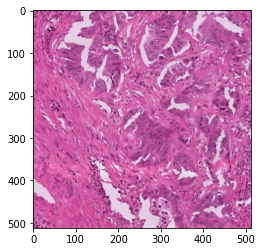

In [ ]:
plt.imshow(output.cpu().permute(1, 2, 0))

In [ ]:
print(batch['label'])

tensor([2, 2, 3, 1, 0, 3, 2, 2, 1, 0, 2, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 0, 3, 2, 2, 2, 2, 2])


# Model

In [ ]:
class NN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # self.num_classes = num_classes
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=num_classes, bias=True, ))#,
                        #  nn.ReLU(),
                        #  nn.Linear(in_features=1000, out_features=num_classes, bias=True))
        print(self.model)

    def forward(self, dictionary):
      return {'label': self.model(dictionary['img'])}

    def prediction(self, dictionary):
        return {'label': torch.argmax(self.forward(dictionary)['label'], dim=1)}

model = NN(num_classes=num_classes).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# # testing
# model.eval()
# a = dict_to_device(batch, 'cuda')['label'].cpu().numpy()
# sm = nn.Softmax(dim=1)
# b = sm(model(dict_to_device(batch, 'cuda'))['label'].cpu()).detach().numpy()
# batch = next(iterator)
# batch = dict_to_device(batch, 'cuda')
# a = np.append(a, batch['label'].cpu().numpy())
# b = np.append(b, sm(model(batch)['label'].cpu()).detach().numpy(), axis=0)
# roc_auc_score(a,b,multi_class='ovr')
# # print(a)

In [ ]:
# print(a, b)

# Training

Helper function to find until which layer we want to freeze 

In [ ]:
# # helper function 
# layer_num = 7

# for child in model.children(): # child = ResNet
#   cnt = 0
#   for child1 in child.children(): # child1 = layers
#     cnt += 1
#     if cnt < layer_num:
#       for param in child1.parameters():
#         param.requires_grad = False
#       print(child1)
#   break

## Training loop

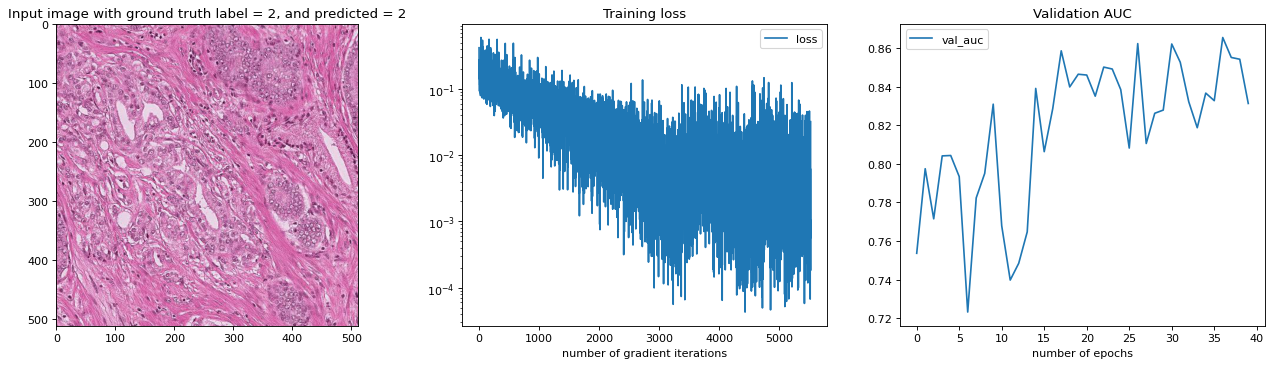

Epoch 40, iteration 16 of 135 (11 %), loss=0.00017132950631011695
val_acc = [0.7536700967969577, 0.7974909781019552, 0.7715317019616237, 0.804134162574878, 0.8043430021158908, 0.7934081542091355, 0.7232336529713725, 0.7823761621664779, 0.7950653226052193, 0.8309314920321682, 0.7678929692733921, 0.7398027758571726, 0.7484967241013265, 0.7647600190803586, 0.8390836412381028, 0.8063206969366887, 0.828576486753608, 0.8585645758425425, 0.8398603672845424, 0.8464370071608125, 0.8460181074278674, 0.8350730376318816, 0.8501336697746907, 0.8491436760855002, 0.8384761967349362, 0.8081914999733015, 0.8623016193181936, 0.81055574234033, 0.8262100777322043, 0.8278668208297659, 0.8621000037592088, 0.852636090092102, 0.8321870120528907, 0.8187233804527845, 0.8366664525107079, 0.8327453031691976, 0.8654651564221081, 0.8551298461358077, 0.8542058779313982, 0.8312932493176944, 0.8421925353501752]


In [ ]:
# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

sm = nn.Softmax(dim=1)

weights = torch.FloatTensor(train_loader.dataset.ratio).to('cuda') # balancing data in loss

num_epochs = 41
losses = []
# val_losses = []
val_accs = []
val_acc = 0
for epoch in range(num_epochs):
    train_iter = iter(train_loader)
    model.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = model(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        loss = torch.nn.functional.cross_entropy(pred['label'], nn.functional.one_hot(batch_gpu['label'], num_classes=num_classes).double(), weight = weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        
        ## plotting ##
        if i%20==0:
            # clear figures for a new update
            for ax in axes:
                ax.cla()
            # plot the predicted pose and ground truth pose on the image
            plotImage(batch_cpu['img'][0], ax=axes[0])
            
            ## !!!! code below is dependent on the prediction code. The commented code below is a better choice!
            axes[0].set_title('Input image with ground truth label = {}, and predicted = {}'.format(batch_cpu['label'][0], int(torch.argmax(pred_cpu['label'][0]))))
            # axes[0].set_title('Input image with ground truth label = {}, and predicted = {}'.format(batch_cpu['label'][0], int(model.prediction(batch_gpu)['label'][0])))

            # plot the training error on a log plot
            axes[1].plot(losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # plot the training error on a log plot
            # axes[2].plot(val_losses, label='val_loss')
            axes[2].plot(val_accs, label='val_auc')
            # axes[2].set_yscale('log')
            axes[2].set_title('Validation AUC')
            axes[2].set_xlabel('number of epochs')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch {}, iteration {} of {} ({} %), loss={}\nval_auc = {}".format(epoch, i, len(train_loader), 100*i//len(train_loader), losses[-1], val_accs))
            # print("Training for the specified amount of epochs would take long.\nStop the process once you verified that the training works on your setup.")

    ## Validation
    val_iter = iter(val_loader)
    model.eval()
    # val_loss = 0
    val_acc = 0
    pred_val = None
    label = None
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        # pred = model(batch_gpu)
        # pred_cpu = dict_to_device(pred, 'cpu')
        # MSE loss
        # val_loss += (torch.nn.functional.cross_entropy(pred['label'], nn.functional.one_hot(batch_gpu['label'], num_classes=num_classes).double()) * batch_gpu['label'].shape[0] / batch_size).item()
        ## Accuracy
#         val_acc += (torch.sum(model.prediction(batch_gpu)['label'] == batch_gpu['label'])).item()
        ## AUC
        if pred_val is None:
            pred_val = sm(model(batch_gpu)['label'].cpu()).detach().numpy()
            label = batch_cpu['label'].numpy()
        else:
            pred_val = np.append(pred_val, sm(model(batch_gpu)['label'].cpu()).detach().numpy(), axis=0)
            label = np.append(label, batch_cpu['label'].numpy())
            
            
    ## AUC
    val_acc = roc_auc_score(label,pred_val,multi_class='ovr')
    val_accs.append(val_acc)

    ## Accuracy
#     val_accs.append(val_acc/len(dataset_val) * 100)

    ## saving the model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'val_AUC': val_acc
    }, model_results_path + '_' + str(epoch) + '_' + str(val_acc))

    # clear output window and diplay updated figure
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print("Epoch {}, iteration {} of {} ({} %), loss={}\nval_acc = {}".format(epoch, i, len(train_loader), 100*i//len(train_loader), losses[-1], val_accs))

plt.close('all')


In [ ]:
import pickle

with open('loss/losses_baseline_model_norm3ref_balanced', 'wb') as f:
    pickle.dump(losses, f)

with open('loss/val_auc_baseline_model_norm3ref_balanced', 'wb') as f:
    pickle.dump(val_accs, f)

In [ ]:
# checkpoint = torch.load(model_results_path)
# print(checkpoint['val_AUC'])

# Test

In [ ]:
#### UNBALANCED TRAINING ####
# model_path = 'model/baseline_model_original_29_0.8621881864942695'
# pred_file = 'test_results/original_test_pred_unbalanced_without_aug.npy'
# label_file = 'test_results/original_test_label_unbalanced_without_aug.npy'

# pred_file = 'test_results/colorado_original_test_pred_unbalanced_without_aug.npy'
# label_file = 'test_results/colorado_original_test_label_unbalanced_without_aug.npy'

# model_path = 'model/baseline_model_norm1ref_22_0.8391057147411503'
# pred_file = 'test_results/norm1ref_test_pred_unbalanced_without_aug.npy'
# label_file = 'test_results/norm1ref_test_label_unbalanced_without_aug.npy'

# pred_file = 'test_results/colorado_norm1ref_test_pred_unbalanced_without_aug.npy'
# label_file = 'test_results/colorado_norm1ref_test_label_unbalanced_without_aug.npy'

# model_path = 'model/baseline_model_norm3ref_30_0.8649177205409141'
# pred_file = 'test_results/norm3ref_test_pred_unbalanced_without_aug.npy'
# label_file = 'test_results/norm3ref_test_label_unbalanced_without_aug.npy'

# pred_file = 'test_results/colorado_norm3ref_test_pred_unbalanced_without_aug.npy'
# label_file = 'test_results/colorado_norm3ref_test_label_unbalanced_without_aug.npy'


#### BALANCED TRAINING ####
model_path = 'model/baseline_model_original_balanced_27_0.8519740036219422'
# pred_file = 'test_results/original_test_pred_balanced_without_aug.npy'
# label_file = 'test_results/original_test_label_balanced_without_aug.npy'

pred_file = 'test_results/colorado_original_test_pred_balanced_without_aug.npy'
label_file = 'test_results/colorado_original_test_label_balanced_without_aug.npy'

# model_path = 'model/baseline_model_norm1ref_balanced_37_0.8329626000380735'
# pred_file = 'test_results/norm1ref_test_pred_balanced_without_aug.npy'
# label_file = 'test_results/norm1ref_test_label_balanced_without_aug.npy'

# pred_file = 'test_results/colorado_norm1ref_test_pred_balanced_without_aug.npy'
# label_file = 'test_results/colorado_norm1ref_test_label_balanced_without_aug.npy'

# model_path = 'model/baseline_model_norm3ref_balanced_36_0.8654651564221081'
# pred_file = 'test_results/norm3ref_test_pred_balanced_without_aug.npy'
# label_file = 'test_results/norm3ref_test_label_balanced_without_aug.npy'

# pred_file = 'test_results/colorado_norm3ref_test_pred_balanced_without_aug.npy'
# label_file = 'test_results/colorado_norm3ref_test_label_balanced_without_aug.npy'

## load data

In [ ]:
# dataset_test = VPCDataset(path_VPC, test_slides_vpc, map_vpc, transform=transforms.ToTensor(), store_all_imgs=True)
# test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=0)
colorado_test = ColoradoDataset(path_colorado, test_slides_colorado, map_colorado, slide_sizes, slide_magnifications, transform=transforms.ToTensor(), store_all_imgs=False)
test_loader = DataLoader(dataset=colorado_test, batch_size=batch_size, num_workers=0)

# [0, 1, 2, 3, 4, 5, 6, 94, 96, 97, 98, 99]

## load model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sm = nn.Softmax(dim=1)

In [ ]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
test_iter = iter(test_loader)
model.eval()
pred_test = None
label = None
for i in range(len(test_loader)):
    batch_cpu = next(test_iter)
    batch_gpu = dict_to_device(batch_cpu, 'cuda')
    
    if pred_test is None:
        pred_test = sm(model(batch_gpu)['label'].cpu()).detach().numpy()
        label = batch_cpu['label'].numpy()
    else:
        pred_test = np.append(pred_test, sm(model(batch_gpu)['label'].cpu()).detach().numpy(), axis=0)
        label = np.append(label, batch_cpu['label'].numpy())

In [ ]:
with open(pred_file, 'wb') as f:
    np.save(f, pred_test)
with open(label_file, 'wb') as f:
    np.save(f, label)

In [ ]:
with open(pred_file, 'rb') as f:
    a = np.load(f)

In [ ]:
if (a == pred_test).all():
    print('Array is successfully saved')
else:
    print('ERROR: problem in the saved array')

Array is successfully saved


In [ ]:
print(pred_test)

[[9.9999797e-01 1.5198752e-12 1.9383522e-06 7.2303280e-08]
 [9.4035447e-01 2.1057999e-02 3.8453877e-02 1.3366481e-04]
 [9.9998760e-01 1.3400561e-09 1.2362319e-05 3.4397541e-08]
 ...
 [8.7181534e-06 1.7403470e-09 9.9989748e-01 9.3799805e-05]
 [3.7812692e-10 8.9730002e-14 1.0000000e+00 3.9246258e-12]
 [4.0394343e-03 4.2787083e-06 9.9346304e-01 2.4933114e-03]]


In [ ]:
print(len(label))
cnt = np.zeros((4,1))
for l in label:
    cnt[l] += 1
cnt = cnt / np.sum(cnt)
print(cnt)

1658
[[0.43787696]
 [0.20084439]
 [0.31845597]
 [0.04282268]]


In [ ]:
print(roc_auc_score(label,a,multi_class='ovr'))

0.8009036338496778


In [ ]:
print(roc_auc_score(label,pred_test,multi_class='ovr'))

0.8009036338496778
